In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [15]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Import Data

In [5]:
df = pd.read_csv("data/daily_min_temp.csv", index_col=["Date"], parse_dates=["Date"])
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


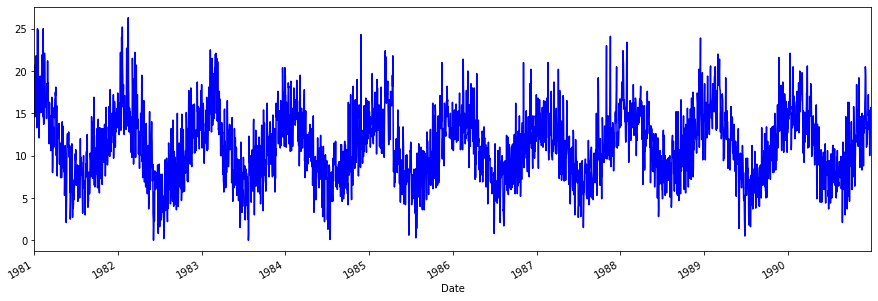

In [9]:
df.Temp.plot(figsize=(15,5), color='b')

# Dataset Splitting

In [11]:
ts_train, ts_test = train_test_split(df, test_size=0.2, shuffle=False)
ts_train.shape, ts_test.shape

((2920, 1), (730, 1))

# Dataset & Dataloader

In [12]:
from jcopdl.utils.dataloader import TimeSeriesDataset
from torch.utils.data import DataLoader

In [14]:
seq_len = 14
bs = 32

train_set = TimeSeriesDataset(ts_train, "Temp", seq_len)
trainloader = DataLoader(train_set, batch_size=bs)

test_set = TimeSeriesDataset(ts_test, "Temp", seq_len)
testloader = DataLoader(test_set, batch_size=bs)

(N, S, F): (208, 14, 1)
Note: last 7 data excluded

(N, S, F): (52, 14, 1)
Note: last 1 data excluded



# Arsitektur & Config

In [20]:
class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout):
        super().__init__()
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = self.fc(x)
        return x, hidden        

In [23]:
config = set_config({
    "input_size": train_set.n_feature,
    "seq_len": train_set.n_seq,
    "output_size": 1,
    "hidden_size": 64,
    "num_layers": 2,
    "dropout": 0
})

# Training Preparation -> MCOC

In [27]:
model = RNN(config.input_size, config.output_size, config.hidden_size, config.num_layers, config.dropout).to(device)
criterion = nn.MSELoss(reduction="mean")
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir="model/rnn")

# Training

In [28]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == "train":
        model.train()
    elif mode == "test":
        model.eval()
    cost = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output, hidden = model(feature, None)
        loss = criterion(output, target)
        
        if mode == "train":
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        cost += loss.item() * feature.shape[0]
    cost = cost / len(dataset)
    return cost



Epoch     1
Train_cost  = 129.8290 | Test_cost  = 116.5001 | 




Epoch     2
Train_cost  = 98.3145 | Test_cost  = 90.0895 | 




Epoch     3
Train_cost  = 76.8075 | Test_cost  = 73.6408 | 




Epoch     4
Train_cost  = 63.7697 | Test_cost  = 63.4403 | 




Epoch     5
Train_cost  = 55.2588 | Test_cost  = 55.9684 | 




Epoch     6
Train_cost  = 48.8243 | Test_cost  = 49.9787 | 




Epoch     7
Train_cost  = 43.5548 | Test_cost  = 44.8685 | 




Epoch     8
Train_cost  = 39.0470 | Test_cost  = 40.4394 | 




Epoch     9
Train_cost  = 35.1670 | Test_cost  = 36.6118 | 




Epoch    10
Train_cost  = 31.8471 | Test_cost  = 33.3269 | 




Epoch    11
Train_cost  = 29.0278 | Test_cost  = 30.5249 | 




Epoch    12
Train_cost  = 26.6504 | Test_cost  = 28.1484 | 




Epoch    13
Train_cost  = 24.6594 | Test_cost  = 26.1442 | 




Epoch    14
Train_cost  = 23.0036 | Test_cost  = 24.4634 | 




Epoch    15
Train_cost  = 21.6367 | Test_cost  = 23.0619 | 




Epoch    16
Train_cost  = 20.5165 | Test_cost  = 21.8997 | 




Epoch    17
Train_cost  = 19.6057 | Test_cost  = 20.9412 | 




Epoch    18
Train_cost  = 18.8707 | Test_cost  = 20.1549 | 




Epoch    19
Train_cost  = 18.2822 | Test_cost  = 19.5131 | 




Epoch    20
Train_cost  = 17.8148 | Test_cost  = 18.9915 | 


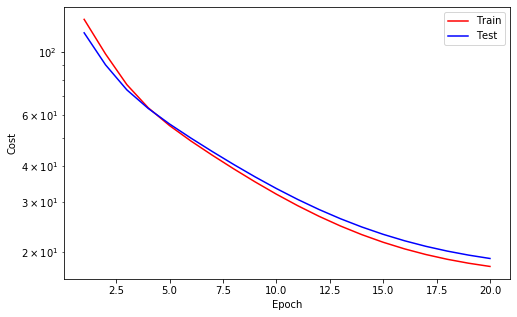



Epoch    21
Train_cost  = 17.4464 | Test_cost  = 18.5694 | 




Epoch    22
Train_cost  = 17.1583 | Test_cost  = 18.2291 | 




Epoch    23
Train_cost  = 16.9346 | Test_cost  = 17.9555 | 




Epoch    24
Train_cost  = 16.7620 | Test_cost  = 17.7360 | 




Epoch    25
Train_cost  = 16.6298 | Test_cost  = 17.5601 | 




Epoch    26
Train_cost  = 16.5290 | Test_cost  = 17.4193 | 




Epoch    27
Train_cost  = 16.4525 | Test_cost  = 17.3065 | 




Epoch    28
Train_cost  = 16.3945 | Test_cost  = 17.2161 | 




Epoch    29
Train_cost  = 16.3506 | Test_cost  = 17.1433 | 




Epoch    30
Train_cost  = 16.3172 | Test_cost  = 17.0847 | 




Epoch    31
Train_cost  = 16.2916 | Test_cost  = 17.0371 | 




Epoch    32
Train_cost  = 16.2718 | Test_cost  = 16.9983 | 




Epoch    33
Train_cost  = 16.2560 | Test_cost  = 16.9664 | 




Epoch    34
Train_cost  = 16.2430 | Test_cost  = 16.9399 | 




Epoch    35
Train_cost  = 16.2319 | Test_cost  = 16.9174 | 




Epoch    36
Train_cost  = 16.2220 | Test_cost  = 16.8981 | 




Epoch    37
Train_cost  = 16.2125 | Test_cost  = 16.8809 | 




Epoch    38
Train_cost  = 16.2028 | Test_cost  = 16.8649 | 




Epoch    39
Train_cost  = 16.1923 | Test_cost  = 16.8493 | 




Epoch    40
Train_cost  = 16.1800 | Test_cost  = 16.8327 | 


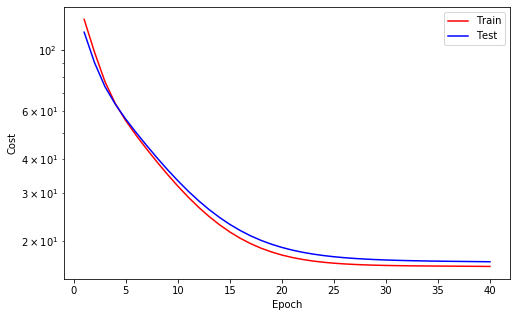



Epoch    41
Train_cost  = 16.1645 | Test_cost  = 16.8132 | 




Epoch    42
Train_cost  = 16.1431 | Test_cost  = 16.7868 | 




Epoch    43
Train_cost  = 16.1094 | Test_cost  = 16.7428 | 




Epoch    44
Train_cost  = 16.0428 | Test_cost  = 16.6379 | 




Epoch    45
Train_cost  = 15.8451 | Test_cost  = 16.3252 | 




Epoch    46
Train_cost  = 15.4040 | Test_cost  = 15.8104 | 




Epoch    47
Train_cost  = 14.5320 | Test_cost  = 14.7078 | 




Epoch    48
Train_cost  = 13.5390 | Test_cost  = 13.9846 | 




Epoch    49
Train_cost  = 12.9504 | Test_cost  = 13.2897 | 




Epoch    50
Train_cost  = 12.2701 | Test_cost  = 12.4353 | 




Epoch    51
Train_cost  = 11.5746 | Test_cost  = 11.6329 | 




Epoch    52
Train_cost  = 11.0095 | Test_cost  = 10.9290 | 




Epoch    53
Train_cost  = 10.5441 | Test_cost  = 10.3904 | 




Epoch    54
Train_cost  = 10.1266 | Test_cost  = 9.9577 | 




Epoch    55
Train_cost  = 9.7743 | Test_cost  = 9.5745 | 




Epoch    56
Train_cost  = 9.4963 | Test_cost  = 9.2466 | 




Epoch    57
Train_cost  = 9.2726 | Test_cost  = 8.9561 | 




Epoch    58
Train_cost  = 9.0628 | Test_cost  = 8.6963 | 




Epoch    59
Train_cost  = 8.8661 | Test_cost  = 8.4674 | 




Epoch    60
Train_cost  = 8.6978 | Test_cost  = 8.2706 | 


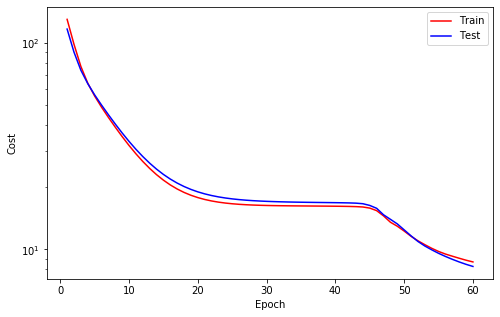



Epoch    61
Train_cost  = 8.5546 | Test_cost  = 8.0925 | 




Epoch    62
Train_cost  = 8.4234 | Test_cost  = 7.9262 | 




Epoch    63
Train_cost  = 8.2976 | Test_cost  = 7.7759 | 




Epoch    64
Train_cost  = 8.1784 | Test_cost  = 7.6407 | 




Epoch    65
Train_cost  = 8.0692 | Test_cost  = 7.5171 | 




Epoch    66
Train_cost  = 7.9710 | Test_cost  = 7.4036 | 




Epoch    67
Train_cost  = 7.8811 | Test_cost  = 7.2971 | 




Epoch    68
Train_cost  = 7.7963 | Test_cost  = 7.1970 | 




Epoch    69
Train_cost  = 7.7156 | Test_cost  = 7.1040 | 




Epoch    70
Train_cost  = 7.6399 | Test_cost  = 7.0176 | 




Epoch    71
Train_cost  = 7.5697 | Test_cost  = 6.9373 | 




Epoch    72
Train_cost  = 7.5048 | Test_cost  = 6.8625 | 




Epoch    73
Train_cost  = 7.4447 | Test_cost  = 6.7925 | 




Epoch    74
Train_cost  = 7.3887 | Test_cost  = 6.7269 | 




Epoch    75
Train_cost  = 7.3365 | Test_cost  = 6.6653 | 




Epoch    76
Train_cost  = 7.2877 | Test_cost  = 6.6073 | 




Epoch    77
Train_cost  = 7.2420 | Test_cost  = 6.5527 | 




Epoch    78
Train_cost  = 7.1991 | Test_cost  = 6.5011 | 




Epoch    79
Train_cost  = 7.1588 | Test_cost  = 6.4523 | 




Epoch    80
Train_cost  = 7.1207 | Test_cost  = 6.4061 | 


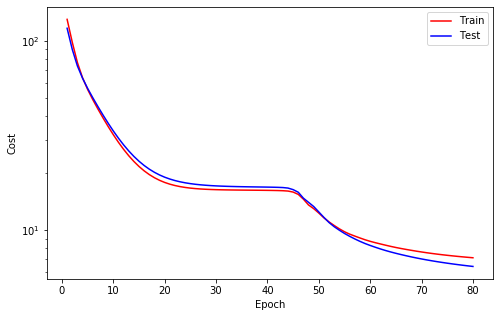



Epoch    81
Train_cost  = 7.0846 | Test_cost  = 6.3624 | 




Epoch    82
Train_cost  = 7.0505 | Test_cost  = 6.3209 | 




Epoch    83
Train_cost  = 7.0181 | Test_cost  = 6.2815 | 




Epoch    84
Train_cost  = 6.9873 | Test_cost  = 6.2441 | 




Epoch    85
Train_cost  = 6.9580 | Test_cost  = 6.2086 | 




Epoch    86
Train_cost  = 6.9302 | Test_cost  = 6.1748 | 




Epoch    87
Train_cost  = 6.9038 | Test_cost  = 6.1426 | 




Epoch    88
Train_cost  = 6.8787 | Test_cost  = 6.1119 | 




Epoch    89
Train_cost  = 6.8547 | Test_cost  = 6.0826 | 




Epoch    90
Train_cost  = 6.8319 | Test_cost  = 6.0546 | 




Epoch    91
Train_cost  = 6.8101 | Test_cost  = 6.0279 | 




Epoch    92
Train_cost  = 6.7893 | Test_cost  = 6.0022 | 




Epoch    93
Train_cost  = 6.7694 | Test_cost  = 5.9777 | 




Epoch    94
Train_cost  = 6.7504 | Test_cost  = 5.9541 | 




Epoch    95
Train_cost  = 6.7321 | Test_cost  = 5.9315 | 




Epoch    96
Train_cost  = 6.7146 | Test_cost  = 5.9098 | 




Epoch    97
Train_cost  = 6.6977 | Test_cost  = 5.8889 | 




Epoch    98
Train_cost  = 6.6815 | Test_cost  = 5.8688 | 




Epoch    99
Train_cost  = 6.6659 | Test_cost  = 5.8494 | 




Epoch   100
Train_cost  = 6.6509 | Test_cost  = 5.8307 | 


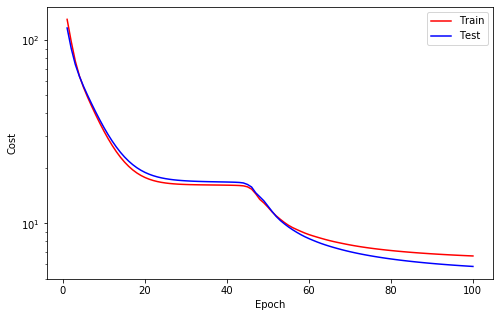



Epoch   101
Train_cost  = 6.6364 | Test_cost  = 5.8127 | 




Epoch   102
Train_cost  = 6.6224 | Test_cost  = 5.7954 | 




Epoch   103
Train_cost  = 6.6089 | Test_cost  = 5.7786 | 




Epoch   104
Train_cost  = 6.5958 | Test_cost  = 5.7624 | 




Epoch   105
Train_cost  = 6.5831 | Test_cost  = 5.7468 | 




Epoch   106
Train_cost  = 6.5708 | Test_cost  = 5.7316 | 




Epoch   107
Train_cost  = 6.5589 | Test_cost  = 5.7170 | 




Epoch   108
Train_cost  = 6.5473 | Test_cost  = 5.7028 | 




Epoch   109
Train_cost  = 6.5361 | Test_cost  = 5.6891 | 




Epoch   110
Train_cost  = 6.5252 | Test_cost  = 5.6758 | 




Epoch   111
Train_cost  = 6.5145 | Test_cost  = 5.6629 | 




Epoch   112
Train_cost  = 6.5042 | Test_cost  = 5.6504 | 




Epoch   113
Train_cost  = 6.4941 | Test_cost  = 5.6382 | 




Epoch   114
Train_cost  = 6.4842 | Test_cost  = 5.6264 | 




Epoch   115
Train_cost  = 6.4746 | Test_cost  = 5.6150 | 




Epoch   116
Train_cost  = 6.4652 | Test_cost  = 5.6038 | 




Epoch   117
Train_cost  = 6.4561 | Test_cost  = 5.5930 | 




Epoch   118
Train_cost  = 6.4471 | Test_cost  = 5.5825 | 




Epoch   119
Train_cost  = 6.4383 | Test_cost  = 5.5722 | 




Epoch   120
Train_cost  = 6.4297 | Test_cost  = 5.5623 | 


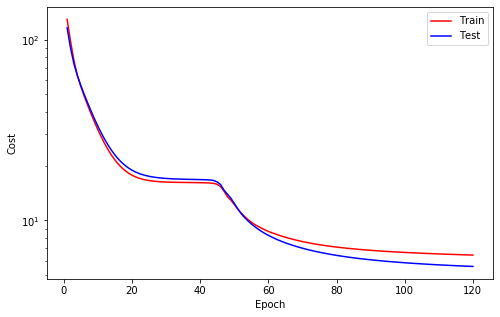



Epoch   121
Train_cost  = 6.4213 | Test_cost  = 5.5526 | 




Epoch   122
Train_cost  = 6.4131 | Test_cost  = 5.5431 | 




Epoch   123
Train_cost  = 6.4050 | Test_cost  = 5.5339 | 




Epoch   124
Train_cost  = 6.3971 | Test_cost  = 5.5250 | 




Epoch   125
Train_cost  = 6.3894 | Test_cost  = 5.5162 | 




Epoch   126
Train_cost  = 6.3818 | Test_cost  = 5.5077 | 




Epoch   127
Train_cost  = 6.3743 | Test_cost  = 5.4994 | 




Epoch   128
Train_cost  = 6.3670 | Test_cost  = 5.4914 | 




Epoch   129
Train_cost  = 6.3598 | Test_cost  = 5.4835 | 




Epoch   130
Train_cost  = 6.3528 | Test_cost  = 5.4759 | 




Epoch   131
Train_cost  = 6.3458 | Test_cost  = 5.4684 | 




Epoch   132
Train_cost  = 6.3390 | Test_cost  = 5.4612 | 




Epoch   133
Train_cost  = 6.3323 | Test_cost  = 5.4541 | 




Epoch   134
Train_cost  = 6.3257 | Test_cost  = 5.4473 | 




Epoch   135
Train_cost  = 6.3192 | Test_cost  = 5.4406 | 




Epoch   136
Train_cost  = 6.3129 | Test_cost  = 5.4341 | 




Epoch   137
Train_cost  = 6.3066 | Test_cost  = 5.4277 | 




Epoch   138
Train_cost  = 6.3004 | Test_cost  = 5.4215 | 




Epoch   139
Train_cost  = 6.2943 | Test_cost  = 5.4155 | 




Epoch   140
Train_cost  = 6.2883 | Test_cost  = 5.4097 | 


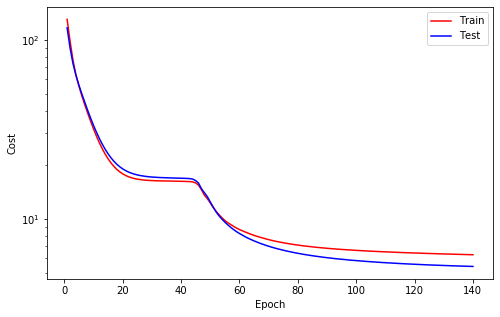



Epoch   141
Train_cost  = 6.2824 | Test_cost  = 5.4040 | 




Epoch   142
Train_cost  = 6.2766 | Test_cost  = 5.3985 | 




Epoch   143
Train_cost  = 6.2709 | Test_cost  = 5.3931 | 




Epoch   144
Train_cost  = 6.2652 | Test_cost  = 5.3878 | 




Epoch   145
Train_cost  = 6.2596 | Test_cost  = 5.3827 | 




Epoch   146
Train_cost  = 6.2541 | Test_cost  = 5.3778 | 




Epoch   147
Train_cost  = 6.2486 | Test_cost  = 5.3730 | 




Epoch   148
Train_cost  = 6.2432 | Test_cost  = 5.3683 | 




Epoch   149
Train_cost  = 6.2379 | Test_cost  = 5.3637 | 




Epoch   150
Train_cost  = 6.2327 | Test_cost  = 5.3592 | 




Epoch   151
Train_cost  = 6.2275 | Test_cost  = 5.3549 | 




Epoch   152
Train_cost  = 6.2223 | Test_cost  = 5.3507 | 




Epoch   153
Train_cost  = 6.2172 | Test_cost  = 5.3466 | 




Epoch   154
Train_cost  = 6.2122 | Test_cost  = 5.3426 | 




Epoch   155
Train_cost  = 6.2072 | Test_cost  = 5.3388 | 




Epoch   156
Train_cost  = 6.2023 | Test_cost  = 5.3350 | 




Epoch   157
Train_cost  = 6.1974 | Test_cost  = 5.3313 | 




Epoch   158
Train_cost  = 6.1926 | Test_cost  = 5.3278 | 




Epoch   159
Train_cost  = 6.1878 | Test_cost  = 5.3243 | 




Epoch   160
Train_cost  = 6.1831 | Test_cost  = 5.3209 | 


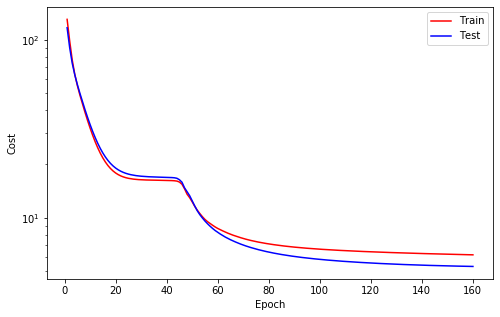



Epoch   161
Train_cost  = 6.1784 | Test_cost  = 5.3176 | 




Epoch   162
Train_cost  = 6.1738 | Test_cost  = 5.3144 | 




Epoch   163
Train_cost  = 6.1692 | Test_cost  = 5.3113 | 




Epoch   164
Train_cost  = 6.1647 | Test_cost  = 5.3083 | 




Epoch   165
Train_cost  = 6.1602 | Test_cost  = 5.3053 | 




Epoch   166
Train_cost  = 6.1557 | Test_cost  = 5.3024 | 




Epoch   167
Train_cost  = 6.1513 | Test_cost  = 5.2996 | 




Epoch   168
Train_cost  = 6.1469 | Test_cost  = 5.2968 | 




Epoch   169
Train_cost  = 6.1426 | Test_cost  = 5.2942 | 




Epoch   170
Train_cost  = 6.1383 | Test_cost  = 5.2915 | 




Epoch   171
Train_cost  = 6.1340 | Test_cost  = 5.2890 | 




Epoch   172
Train_cost  = 6.1298 | Test_cost  = 5.2865 | 




Epoch   173
Train_cost  = 6.1256 | Test_cost  = 5.2840 | 




Epoch   174
Train_cost  = 6.1214 | Test_cost  = 5.2816 | 




Epoch   175
Train_cost  = 6.1172 | Test_cost  = 5.2792 | 




Epoch   176
Train_cost  = 6.1130 | Test_cost  = 5.2769 | 




Epoch   177
Train_cost  = 6.1089 | Test_cost  = 5.2747 | 




Epoch   178
Train_cost  = 6.1048 | Test_cost  = 5.2725 | 




Epoch   179
Train_cost  = 6.1007 | Test_cost  = 5.2703 | 




Epoch   180
Train_cost  = 6.0966 | Test_cost  = 5.2682 | 


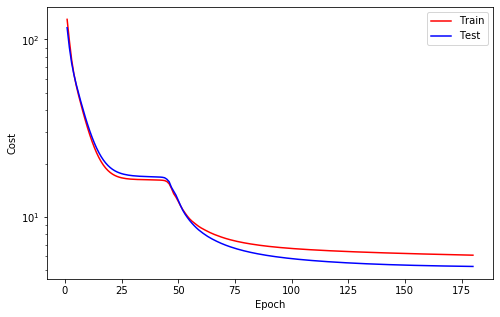



Epoch   181
Train_cost  = 6.0925 | Test_cost  = 5.2661 | 




Epoch   182
Train_cost  = 6.0884 | Test_cost  = 5.2640 | 




Epoch   183
Train_cost  = 6.0843 | Test_cost  = 5.2620 | 




Epoch   184
Train_cost  = 6.0802 | Test_cost  = 5.2601 | 




Epoch   185
Train_cost  = 6.0761 | Test_cost  = 5.2581 | 




Epoch   186
Train_cost  = 6.0720 | Test_cost  = 5.2563 | 




Epoch   187
Train_cost  = 6.0678 | Test_cost  = 5.2544 | 




Epoch   188
Train_cost  = 6.0637 | Test_cost  = 5.2526 | 




Epoch   189
Train_cost  = 6.0596 | Test_cost  = 5.2508 | 




Epoch   190
Train_cost  = 6.0555 | Test_cost  = 5.2491 | 




Epoch   191
Train_cost  = 6.0514 | Test_cost  = 5.2474 | 




Epoch   192
Train_cost  = 6.0472 | Test_cost  = 5.2458 | 




Epoch   193
Train_cost  = 6.0431 | Test_cost  = 5.2442 | 




Epoch   194
Train_cost  = 6.0390 | Test_cost  = 5.2426 | 




Epoch   195
Train_cost  = 6.0348 | Test_cost  = 5.2411 | 




Epoch   196
Train_cost  = 6.0307 | Test_cost  = 5.2396 | 




Epoch   197
Train_cost  = 6.0265 | Test_cost  = 5.2382 | 




Epoch   198
Train_cost  = 6.0223 | Test_cost  = 5.2368 | 




Epoch   199
Train_cost  = 6.0182 | Test_cost  = 5.2355 | 




Epoch   200
Train_cost  = 6.0140 | Test_cost  = 5.2342 | 


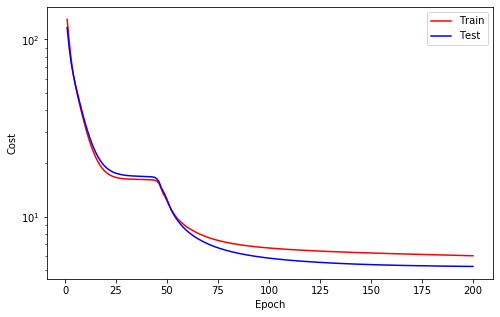



Epoch   201
Train_cost  = 6.0098 | Test_cost  = 5.2329 | 




Epoch   202
Train_cost  = 6.0056 | Test_cost  = 5.2317 | 




Epoch   203
Train_cost  = 6.0014 | Test_cost  = 5.2305 | 




Epoch   204
Train_cost  = 5.9972 | Test_cost  = 5.2294 | 




Epoch   205
Train_cost  = 5.9929 | Test_cost  = 5.2284 | 




Epoch   206
Train_cost  = 5.9887 | Test_cost  = 5.2274 | 




Epoch   207
Train_cost  = 5.9844 | Test_cost  = 5.2265 | 




Epoch   208
Train_cost  = 5.9801 | Test_cost  = 5.2256 | 




Epoch   209
Train_cost  = 5.9757 | Test_cost  = 5.2249 | 




Epoch   210
Train_cost  = 5.9714 | Test_cost  = 5.2242 | 




Epoch   211
Train_cost  = 5.9670 | Test_cost  = 5.2236 | 




Epoch   212
Train_cost  = 5.9626 | Test_cost  = 5.2230 | 




Epoch   213
Train_cost  = 5.9581 | Test_cost  = 5.2226 | 




Epoch   214
Train_cost  = 5.9536 | Test_cost  = 5.2223 | 




Epoch   215
Train_cost  = 5.9491 | Test_cost  = 5.2221 | 




Epoch   216
Train_cost  = 5.9445 | Test_cost  = 5.2221 | 




Epoch   217
Train_cost  = 5.9399 | Test_cost  = 5.2221 | 
==> EarlyStop patience =  1 | Best test_cost: 5.2221




Epoch   218
Train_cost  = 5.9352 | Test_cost  = 5.2223 | 
==> EarlyStop patience =  2 | Best test_cost: 5.2221




Epoch   219
Train_cost  = 5.9305 | Test_cost  = 5.2227 | 
==> EarlyStop patience =  3 | Best test_cost: 5.2221




Epoch   220
Train_cost  = 5.9257 | Test_cost  = 5.2231 | 


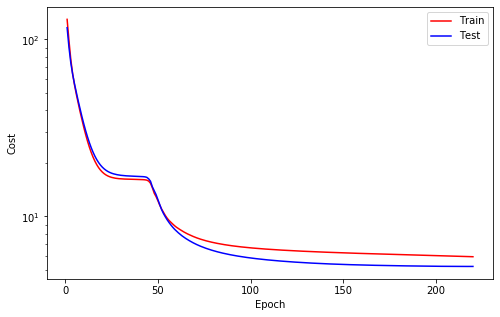

==> EarlyStop patience =  4 | Best test_cost: 5.2221




Epoch   221
Train_cost  = 5.9209 | Test_cost  = 5.2237 | 
==> EarlyStop patience =  5 | Best test_cost: 5.2221
==> Execute Early Stopping at epoch: 221 | Best test_cost: 5.2221
==> Best model is saved at model/rnn


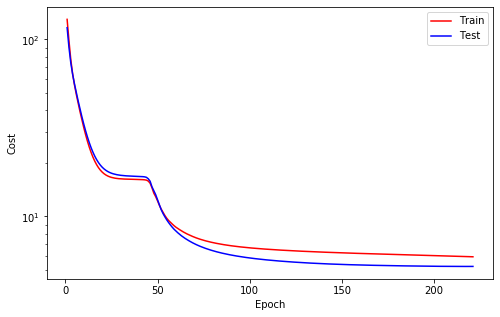

In [29]:
while True:
    train_cost = loop_fn("train", train_set, trainloader, model, criterion, optimizer, device)
    with torch.no_grad():
        test_cost = loop_fn("test", test_set, testloader, model, criterion, optimizer, device)
    
    # Logging
    callback.log(train_cost, test_cost)

    # Checkpoint
    callback.save_checkpoint()
        
    # Runtime Plotting
    callback.cost_runtime_plotting()
    
    # Early Stopping
    if callback.early_stopping(model, monitor="test_cost"):
        callback.plot_cost()
        break

# Sanity Check

In [30]:
from luwiji.rnn import illustration

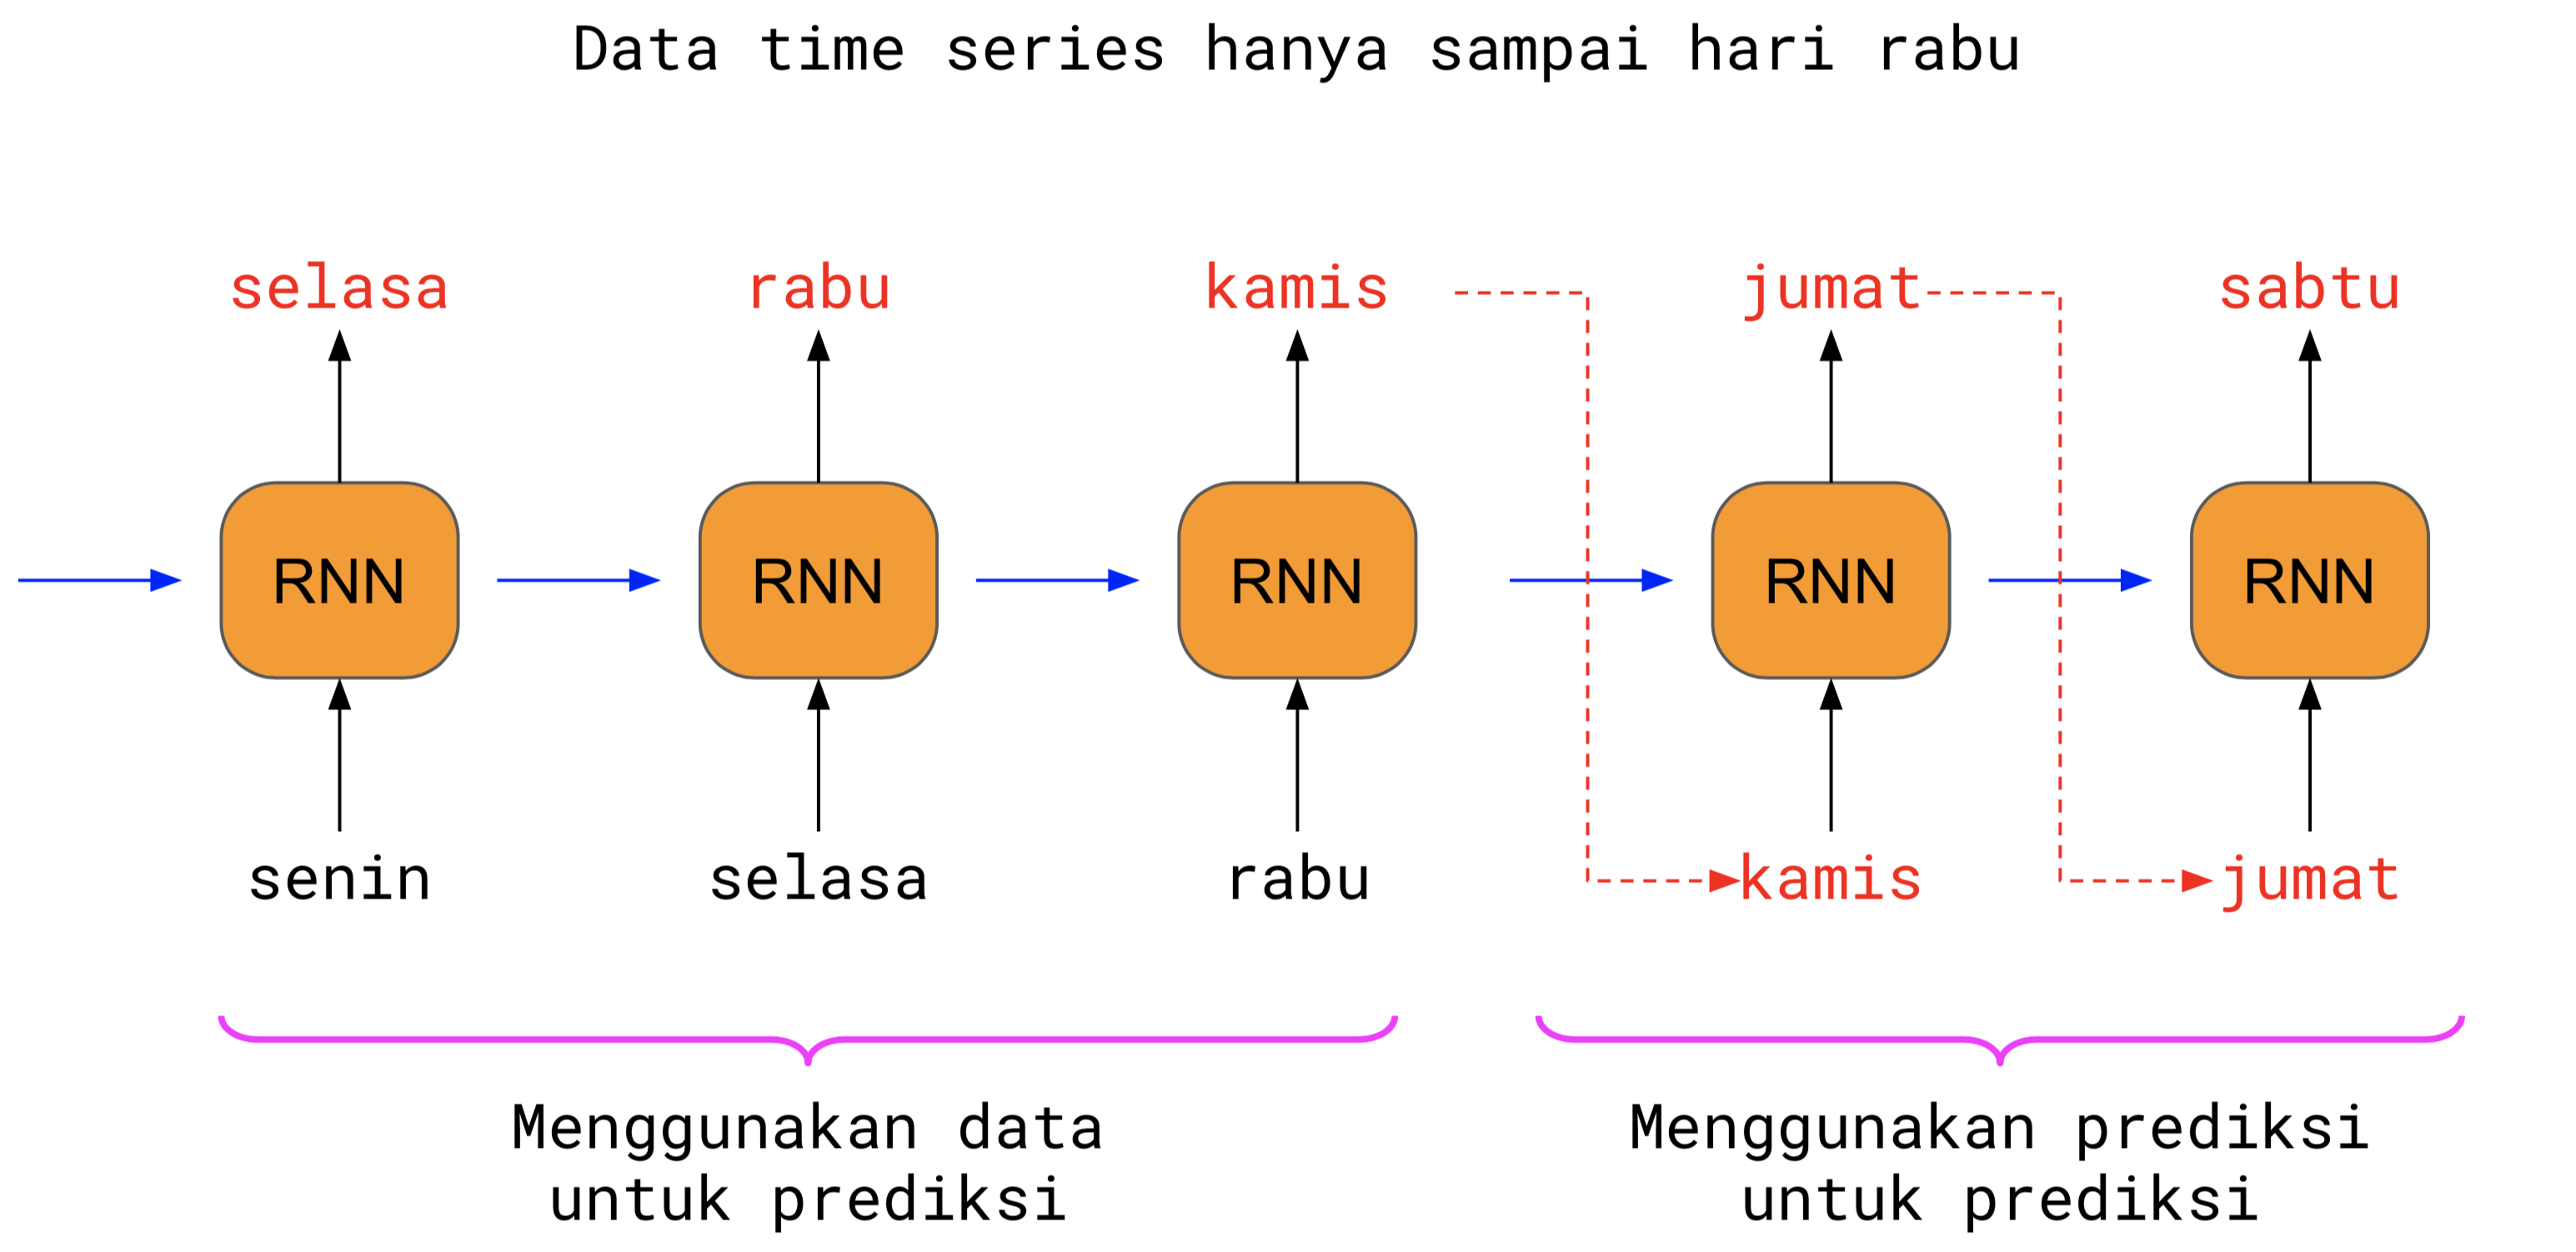

In [31]:
illustration.forecast

In [32]:
from utils import data4pred, pred4pred

In [33]:
train_forecast_set = TimeSeriesDataset(ts_train, "Temp", 1)
trainforecastloader = DataLoader(train_forecast_set)
test_forecast_set = TimeSeriesDataset(ts_test, "Temp", 1)
testforecastloader = DataLoader(test_forecast_set)

(N, S, F): (2919, 1, 1)
Note: last 0 data excluded

(N, S, F): (729, 1, 1)
Note: last 0 data excluded



Text(0.5, 1.0, 'Test')

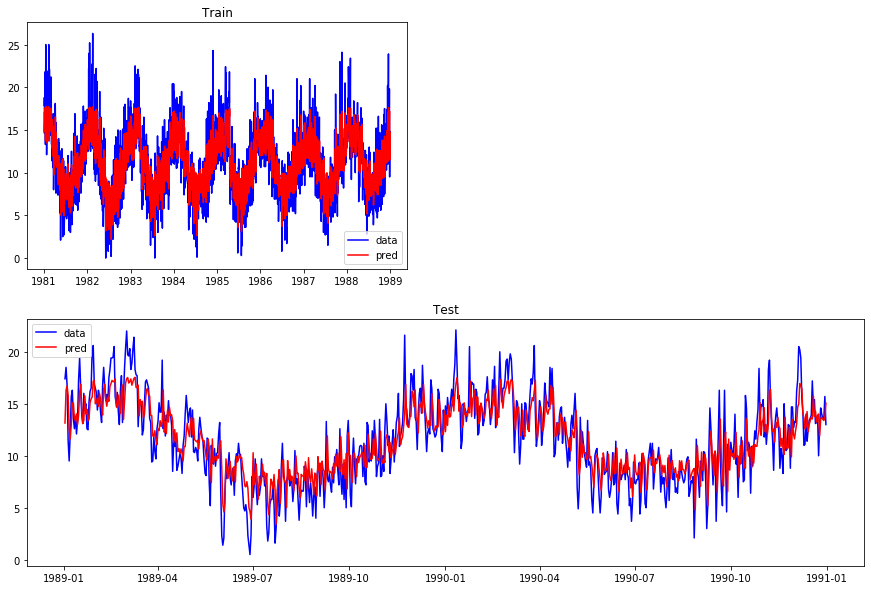

In [34]:
# Data 4 Pred
plt.figure(figsize=(15, 10))

plt.subplot(221)
data4pred(model, train_forecast_set, trainforecastloader, device)
plt.title("Train")

plt.subplot(212)
data4pred(model, test_forecast_set, testforecastloader, device)
plt.title("Test")

Text(0.5, 1.0, 'test')

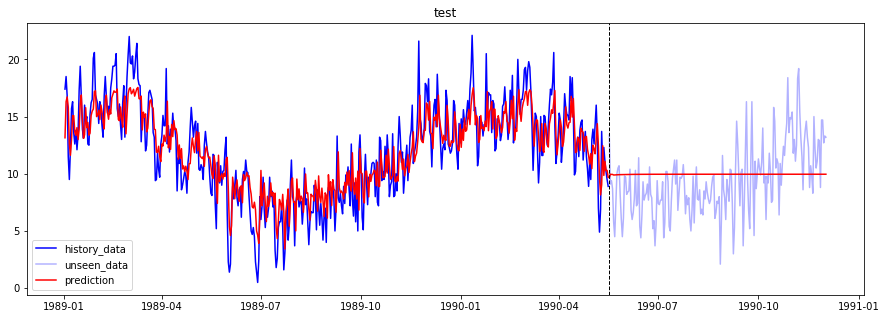

In [35]:
# Pred 4 Pred
plt.figure(figsize=(15, 5))
pred4pred(model, test_forecast_set, testforecastloader, device)
plt.title("test")